# clusterizacion

Primero se procede a la carga de datos. La carga consiste en leer los comentarios de cada uno de los procesos y concatenar los que pertenecen a los comentarios de interes que se quieren guardar. Existe un comentario final que establece donde termina la secuencia de interes.

In [1]:
import sys
sys.path.append("../scripts/")
from funciones_paralectura import carga_de_datos
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
# carga de caminata aleatoria
documento = '../../Battery_Uniform_Distribution_Discharge_Room_Temp_DataSet_2Post/data/Matlab/RW3.mat'
documento_2 = '../../Battery_Uniform_Distribution_Discharge_Room_Temp_DataSet_2Post/data/Matlab/RW5.mat'
comentarios = ['discharge (random walk)',
               'rest (random walk)',
               'rest post random walk discharge']
# for s in comentarios: print(s)
comentario_final = ['charge (after random walk discharge)']
# for s in comentario_final: print(s)
t, v, c, temp, T = carga_de_datos(documento, comentarios, comentario_final, nofinal=False)
t_2, v_2, c_2, temp_2, T_2 = carga_de_datos(documento_2, comentarios, comentario_final, nofinal=False)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000


## Preparacion de datos para data frame
A continuación se preparan los datos encontrando los saltos. Se recorren los arreglos de corriente, voltaje, etc, para encontrar los saltos. Correspondiente a los saltos se guardan distintas etiquetas y series de tiempo por salto.

Para cargar los datos en el data frame, se deben preparar las series de tiempo. Se toma la serie de tiempo correspondiente a la corriente como referencia. Se tomará como inicio el instante anterior al cambio de corriente, justo antes de pasar a 0 de la corriente anterior, es decir, si se estaba en 2 A, se descansa (se pasa a 0 A), y luego se pasa a 3.5 A, entonces se guardará 2.0 , 0.0, 0.0, 0.0, 3.5, 3.5, ... . El fin de la serie se toma como justo el instante antes de pasar a 0 A, siguiendo con el ejemplo anterior, la serie termina en ... , 3.5, 3.5, 0.0

In [3]:
# def guardar_serie_entre(serie, ti, deltaT, tamanno=0):
#     """
#     Funcion para guardar generar las series de tiempo a guardar en el dataframe
#     En especifico: si no se da un tamanno, se asume que es una curva de voltaje y se guarda hasta
#     el punto de mayor voltaje anterior
    
#     Input:
#         serie: serie de tiempo (arreglo de numpy)
#         ti: indice inicial de referencia para guardar los datos
#         deltaT: cantidad de puntos para guardar mas alla de ti
#         tamanno: (opcional) si no se entrega, se asume que es voltaje
#             si se entrega, se asume que se debe guardar desde ti + deltaT, la
#             cantidad de datos dada por tamanno, hacia atras.
    
#     Return:
#         entrega un arreglo de numpy con los datos pedidos
#     """
#     arr = []
        
    
#     fin = ti + deltaT
#     if fin > len(serie): fin = len(serie) - 1
#     ej = serie[ti]
#     i = 0
#     epsilon = 0.1

    
#     if tamanno != 0: i = fin - tamanno
#     else:
#         for idx in range(40):
#             if serie[ti - idx] > ej:
#                 ej = serie[ti - idx]
#                 i = idx
#             elif serie[ti - idx] < ej - epsilon: break
#         i = ti - i
    
#     if i < 0: return np.array(serie[:fin])
    
#     return np.array(serie[i : fin])

def guardar_serie_entre2(serie, ti, corriente=False, inicio=0, fin=0):
    """
    Primero entregar la corriente en el instante ti, para encontrar el inicio y el fin. El inicio de la serie
    sera el final del salto anterior, justo antes de cambiar a 0 A. Termina la serie justo en el instante anterior
    al cambiar a 0 A. Setear corriente en True
    
    Luego, pasar el inicio entregado anteriormente y el fin a las nuevas cargas de datos. Setear corriente en False
    
    """
    if corriente:
        consulta = False
        inicio = ti
        fin = ti + 2
        for i in range(10):
            if ti - i == 0:
                inicio = 0
                break
            elif serie[ti - i] == 0:
                consulta = True
            elif consulta and serie[ti - i] > 0:
                inicio = ti - i
                break
        i = 0
        while serie[ti + i] != 0:
            if ti + i == len(serie) - 1: break
            i += 1
        fin = ti + i
        return [inicio, fin, np.array(serie[inicio:fin])]
    else:
        return [inicio, fin, np.array(serie[inicio:fin])]

A continuación se sigue con la preparación. Guardando las siguientes etiquetas y datos:
- ciclo en que ocurre el salto
- energía entregada antes del momento del salto
    - para esta se intera el producto entre el voltaje y la corriente en el tiempo
- la magnitud del salto
- la media del salto
    - esto conviene cuando ocurren saltos negativos
- serie de tiempo correspondiente a voltaje, como arreglo numpy
- serie de tiempo correspondiente a corriente, como arreglo numpy
- serie de tiempo correspondiente a temperatura, como arreglo numpy
- serie de tiempo correspondiente a tiempo, como arreglo numpy

El objetivo del proceso anterior, es poder tomar cada uno de los saltos, y sacar features iterando sobre ellos.

_PD: hay muchos arreglos que solo se utilizan para graficar_

In [4]:
# creacion de vectores de diferencia de consumo de corriente

# creacion de diccionarios para guardar datos
centro_c = {}
t_salto = {}
pot = {}
pot_salto = {}
dif_salto_c = {}
centro_salto_c = {}
tiempo = {}
ciclo_salto = {}

# saltos = {}
# j = 0

arr_dif_salto_c = []
arr_pot_salto  = []
arr_centro_salto_c  = []
arr_ciclo_salto = []

arr_voltaje_salto = []
arr_corriente_salto = []
arr_tiempo_salto = []
arr_temperatura_salto = []

dx = 90

for i in c.keys():
#     if i == 0: continue
    if i == len(c.keys()) - 1: break
#     print(i)
    # creacion de vectores para guardar datos
    dif_salto_c[i] = []
    centro_c[i] = []
    centro_salto_c[i] = []
    t_salto[i] = []
    pot[i] = []
    pot_salto[i] = []
    tiempo[i] = []
    ciclo_salto[i] = []
    
    # condiciones iniciales
    anterior = 0
    POT = 0
    t_anterior = t[i][0]
    aux_t = 0
    ti = 0
    
    for idx, elem in enumerate(c[i]):
        # lectura de serie de tiempo
        
        dt = t[i][idx] - t_anterior # dt como variable auxiliar
        t_anterior = t[i][idx]
        POT += c[i][idx] * v[i][idx] * dt # se calcula la potencia integrando en el tiempo
        aux_t += dt # su acumulacion de tiempo
        
        centro_c[i].append((elem + anterior) / 2) # centro del salto
        pot[i].append(POT)
        tiempo[i].append(aux_t)
        
        if (elem - anterior >= 0.1):# or (elem - anterior <= -0.1):
            
            # solo entra si ocurre un salto
            
            dif_salto_c[i].append(elem - anterior) # magnitud del salto
            pot_salto[i].append(POT) # energia entregada al momento del salto
            centro_salto_c[i].append((elem + anterior) / 2) # media del salto
            t_salto[i].append(aux_t) # tiempo en que ocurre el salto
            ciclo_salto[i].append(i)
            
#             saltos[j] = {'ciclo': i,
#                         'energia': POT,
#                         'media': (elem + anterior) / 2,
#                         'magnitud': elem - anterior}
            
            arr_dif_salto_c.append(elem - anterior)
            arr_pot_salto.append(POT)
            arr_centro_salto_c.append((elem + anterior) / 2)
            arr_ciclo_salto.append(i)
            
            # como guardar la serie de tiempo de voltaje, corriente y temperatura 
            # del salto en un intervalo de tiempo
            dx = 90
            di = 10
            
#             aux = guardar_serie_entre(v[i], idx, 2*dx)
#             arr_voltaje_salto.append(aux)
#             arr_corriente_salto.append(guardar_serie_entre(c[i], idx, 2*dx, tamanno=len(aux)))
#             arr_tiempo_salto.append(guardar_serie_entre(t[i], idx, 2*dx, tamanno=len(aux)))
#             arr_temperatura_salto.append(guardar_serie_entre(temp[i], idx, 2*dx, tamanno=len(aux)))
            
            inicio, fin, aux = guardar_serie_entre2(c[i], idx, corriente=True)
            arr_corriente_salto.append(aux)
            _, _, aux = guardar_serie_entre2(v[i], idx, inicio=inicio, fin=fin)
            arr_voltaje_salto.append(aux)
            _, _, aux = guardar_serie_entre2(t[i], idx, inicio=inicio, fin=fin)
            arr_tiempo_salto.append(aux)
            _, _, aux = guardar_serie_entre2(temp[i], idx, inicio=inicio, fin=fin)
            arr_temperatura_salto.append(aux)
            
            ti = idx

        anterior = elem
        
        

# creacion de vectores de diferencia de consumo de corriente

# creacion de diccionarios para guardar datos
centro_c_2 = {}
t_salto_2 = {}
pot_2 = {}
pot_salto_2 = {}
dif_salto_c_2 = {}
centro_salto_c_2 = {}
tiempo_2 = {}
ciclo_salto_2 = {}

arr_dif_salto_c_2 = []
arr_pot_salto_2  = []
arr_centro_salto_c_2  = []
arr_ciclo_salto_2 = []

arr_voltaje_salto_2 = []
arr_corriente_salto_2 = []
arr_tiempo_salto_2 = []
arr_temperatura_salto_2 = []

dx_2 = 90

for i in c_2.keys():
#     if i == 0: continue
    if i == len(c_2.keys()) - 1: break
#     print(i)
    # creacion de vectores para guardar datos
    dif_salto_c_2[i] = []
    centro_c_2[i] = []
    centro_salto_c_2[i] = []
    t_salto_2[i] = []
    pot_2[i] = []
    pot_salto_2[i] = []
    tiempo_2[i] = []
    ciclo_salto_2[i] = []
    
    # condiciones iniciales
    anterior_2 = 0
    POT_2 = 0
    t_anterior_2 = t_2[i][0]
    aux_t_2 = 0
    ti_2 = 0
    
    for idx, elem in enumerate(c_2[i]):
        # lectura de serie de tiempo
        
        dt_2 = t_2[i][idx] - t_anterior_2 # dt como variable auxiliar
        t_anterior_2 = t_2[i][idx]
        POT_2 += c_2[i][idx] * v_2[i][idx] * dt_2 # se calcula la potencia integrando en el tiempo
        aux_t_2 += dt_2 # su acumulacion de tiempo
        
        centro_c_2[i].append((elem + anterior_2) / 2) # centro del salto
        pot_2[i].append(POT_2)
        tiempo_2[i].append(aux_t_2)
        
        if (elem - anterior_2 >= 0.1):# or (elem - anterior <= -0.1):
            
            # solo entra si ocurre un salto
            
            dif_salto_c_2[i].append(elem - anterior_2) # magnitud del salto
            pot_salto_2[i].append(POT_2) # energia entregada al momento del salto
            centro_salto_c_2[i].append((elem + anterior_2) / 2) # media del salto
            t_salto_2[i].append(aux_t_2) # tiempo en que ocurre el salto
            ciclo_salto_2[i].append(i)
            
#             saltos[j] = {'ciclo': i,
#                         'energia': POT,
#                         'media': (elem + anterior) / 2,
#                         'magnitud': elem - anterior}
            
            arr_dif_salto_c_2.append(elem - anterior_2)
            arr_pot_salto_2.append(POT_2)
            arr_centro_salto_c_2.append((elem + anterior_2) / 2)
            arr_ciclo_salto_2.append(i)
            
            # como guardar la serie de tiempo de voltaje, corriente y temperatura 
            # del salto en un intervalo de tiempo
            dx_2 = 90
            di_2 = 10
            
#             aux = guardar_serie_entre(v[i], idx, 2*dx)
#             arr_voltaje_salto.append(aux)
#             arr_corriente_salto.append(guardar_serie_entre(c[i], idx, 2*dx, tamanno=len(aux)))
#             arr_tiempo_salto.append(guardar_serie_entre(t[i], idx, 2*dx, tamanno=len(aux)))
#             arr_temperatura_salto.append(guardar_serie_entre(temp[i], idx, 2*dx, tamanno=len(aux)))
            
            inicio_2, fin_2, aux_2 = guardar_serie_entre2(c_2[i], idx, corriente=True)
            arr_corriente_salto_2.append(aux_2)
            _, _, aux_2 = guardar_serie_entre2(v_2[i], idx, inicio=inicio_2, fin=fin_2)
            arr_voltaje_salto_2.append(aux_2)
            _, _, aux_2 = guardar_serie_entre2(t_2[i], idx, inicio=inicio_2, fin=fin_2)
            arr_tiempo_salto_2.append(aux_2)
            _, _, aux_2 = guardar_serie_entre2(temp_2[i], idx, inicio=inicio_2, fin=fin_2)
            arr_temperatura_salto_2.append(aux_2)
            
            ti_2 = idx

        anterior_2 = elem



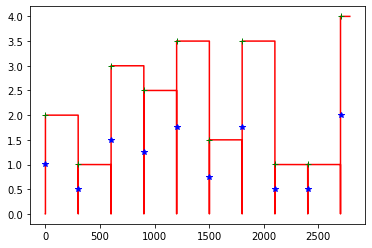

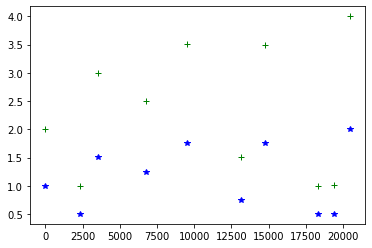

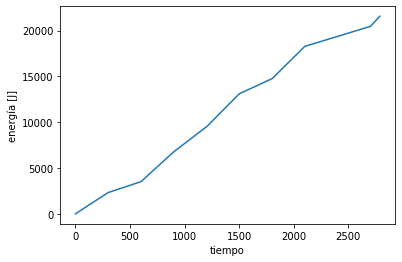

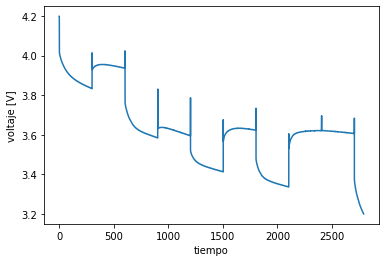

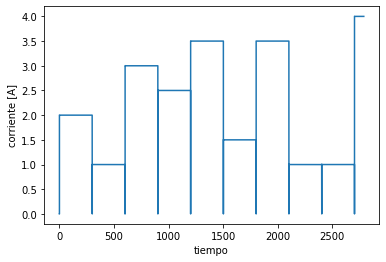

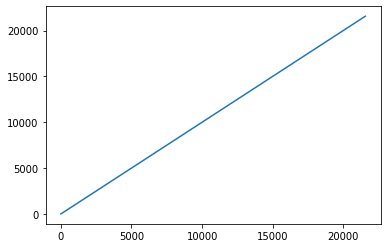

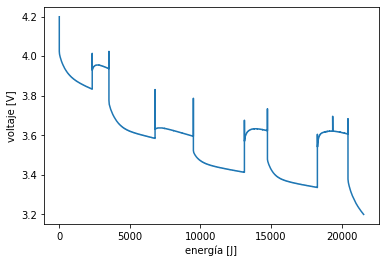

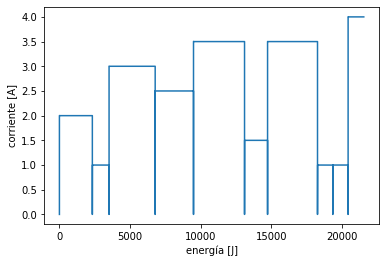

([<matplotlib.lines.Line2D at 0x172f74bb198>],
 Text(17.200000000000003, 0.5, 'corriente [A]'),
 Text(0.5, 17.700000000000003, 'energía [J]'),
 None)

In [5]:
# graficos
plt.plot(tiempo[2], c[2], color='r')
plt.plot(t_salto[2], dif_salto_c[2], '+g')
plt.plot(t_salto[2], centro_salto_c[2], '*b'), plt.show()

plt.plot(pot_salto[2], dif_salto_c[2], '+g')
plt.plot(pot_salto[2], centro_salto_c[2], '*b'), plt.show()

plt.plot(tiempo[2], pot[2]), plt.ylabel('energía [J]'), plt.xlabel('tiempo'), plt.show()
plt.plot(tiempo[2], v[2]), plt.ylabel('voltaje [V]'), plt.xlabel('tiempo'), plt.show()
plt.plot(tiempo[2], c[2]), plt.ylabel('corriente [A]'), plt.xlabel('tiempo'), plt.show()

plt.plot(pot[2], pot[2]), plt.show()
plt.plot(pot[2], v[2]), plt.ylabel('voltaje [V]'), plt.xlabel('energía [J]'), plt.show()
plt.plot(pot[2], c[2]), plt.ylabel('corriente [A]'), plt.xlabel('energía [J]'), plt.show()


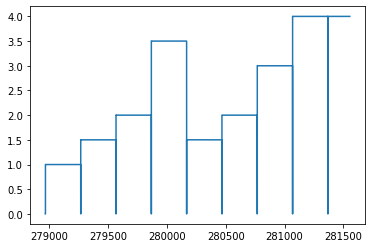

V:  4.199 4.011
C:  0.0 1.0
V:  4.011 3.881
C:  1.0 1.5
V:  3.881 3.746
C:  1.5 2.0
V:  3.746 3.482
C:  2.0 3.5
V:  3.482 3.696
C:  3.5 1.5
V:  3.696 3.591
C:  1.5 2.0
V:  3.591 3.421
C:  2.0 3.0
V:  3.421 3.252
C:  3.0 4.0
V:  3.252 3.2
C:  4.0 4.0


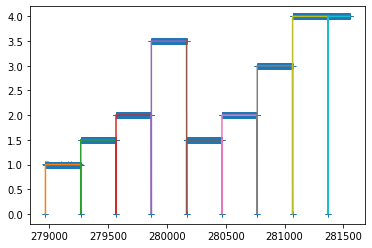

293054.55000000005 293354.79000000004
293354.79000000004 293655.05
2.5 3.5
3.5 1.5
291851.88 294641.94999999995
0 4.0


In [6]:
# mas graficos
plt.plot(t[1], c[1]), plt.show()
plt.plot(t[1], c[1], '+')#, plt.show()
# plt.plot(t[2], c[2], '-r')
# plt.plot(t[1], v[1]), plt.show()
# plt.plot(t[2], c[2]), plt.show()
# plt.plot(t[2], v[2]), plt.show()
for i in range(9):
#     print(len(arr_voltaje_salto[i]))
    print('V: ', arr_voltaje_salto[i][0], arr_voltaje_salto[i][-1])
    print('C: ', arr_corriente_salto[i][0], arr_corriente_salto[i][-1])
#     plt.plot(arr_tiempo_salto[i], arr_voltaje_salto[i]), plt.show()
    plt.plot(arr_tiempo_salto[i], arr_corriente_salto[i])#, plt.show()
plt.show()

print(arr_tiempo_salto[13][0], arr_tiempo_salto[13][-1])
print(arr_tiempo_salto[14][0], arr_tiempo_salto[14][-1])

print(arr_corriente_salto[13][0], arr_corriente_salto[13][-1])
print(arr_corriente_salto[14][0], arr_corriente_salto[14][-1])

print(t[2][0], t[2][-1])
print(c[2][0], c[2][-1])

## Creación de dataframe
Para poder manejar de mejor manera los saltos, se agrupan en un dataframe de pandas. De esta forma, se pueden filtrar y graficar más facilmente. Además de crear nuevas columnas de manera mucho más fácil, y muchas otras facultades sobre los datos

In [7]:
import pandas as pd
saltos = {'ciclo': arr_ciclo_salto,
          'energia': arr_pot_salto,
          'magnitud': arr_dif_salto_c,
          'media': arr_centro_salto_c}
df = pd.DataFrame(saltos, columns=['ciclo', 'energia', 'magnitud', 'media'])
df['voltaje'] = [x for x in arr_voltaje_salto]
df['corriente'] = [x for x in arr_corriente_salto]
df['temperatura'] = [x for x in arr_temperatura_salto]
df['tiempo'] = [x for x in arr_tiempo_salto]


saltos_2 = {'ciclo': arr_ciclo_salto_2,
          'energia': arr_pot_salto_2,
          'magnitud': arr_dif_salto_c_2,
          'media': arr_centro_salto_c_2}
df_2 = pd.DataFrame(saltos_2, columns=['ciclo', 'energia', 'magnitud', 'media'])
df_2['voltaje'] = [x for x in arr_voltaje_salto_2]
df_2['corriente'] = [x for x in arr_corriente_salto_2]
df_2['temperatura'] = [x for x in arr_temperatura_salto_2]
df_2['tiempo'] = [x for x in arr_tiempo_salto_2]


Se agrega una etiqueta correspondiente a la temperatura inicial del momento del salto. Esto es para analizar una componente de estado de salud donde la temperatura almacena la información de la energía disipada por la transformación de energía.

Sin embargo, esta etiqueta no funciona muy bien con algún set de datos, en específico en la batería 3, donde (al parecer) se estropea el sensor de temperatura.

In [8]:
df['temp_ini'] = [x[0] for x in df['temperatura']]
df.head()
df_2['temp_ini'] = [x[0] for x in df_2['temperatura']]
df_2.head()

,ciclo,energia,magnitud,media,voltaje,corriente,temperatura,tiempo,temp_ini
0,1,0.614047,4.005,2.0025,"[4.199, 4.199, 3.833, 3.809, 3.801, 3.795, 3.7...","[0.0, 0.0, 4.005, 3.999, 4.0, 3.999, 4.0, 4.0,...","[20.61039, 20.61039, 20.61039, 20.62594, 20.62...","[274884.25, 274884.5, 274884.54, 274885.540000...",20.61039
1,1,4266.690109,2.007,1.0035,"[3.512, 3.817, 3.842, 3.683, 3.688, 3.693, 3.6...","[4.0, 0.0, 0.0, 2.007, 2.0, 2.0, 2.0, 2.0, 2.0...","[28.18093, 28.18093, 28.18093, 28.18093, 28.21...","[275184.5, 275184.50999999995, 275184.7, 27518...",28.18093
2,1,6510.697143,1.503,0.7515,"[3.72, 3.868, 3.879, 3.763, 3.762, 3.763, 3.76...","[2.0, 0.0, 0.0, 1.503, 1.5, 1.5, 1.5, 1.5, 1.5...","[28.36748, 28.36748, 28.36748, 28.36748, 28.35...","[275484.7, 275484.71, 275485.35, 275485.39, 27...",28.36748
3,1,8200.072656,2.504,1.2520,"[3.733, 3.846, 3.854, 3.657, 3.652, 3.65, 3.64...","[1.5, 0.0, 0.0, 2.504, 2.5, 2.5, 2.5, 2.499, 2...","[27.24822, 27.24822, 27.23267, 27.23267, 27.23...","[275785.35, 275785.36, 275785.81, 275785.85, 2...",27.24822
4,1,10884.859898,0.504,0.2520,"[3.543, 3.731, 3.747, 3.708, 3.711, 3.715, 3.7...","[2.5, 0.0, 0.0, 0.504, 0.5, 0.5, 0.5, 0.5, 0.5...","[28.07212, 28.07212, 28.07212, 28.07212, 28.07...","[276085.81, 276085.82, 276086.28, 276086.33, 2...",28.07212


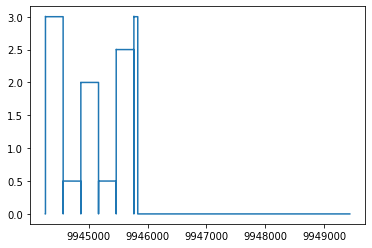

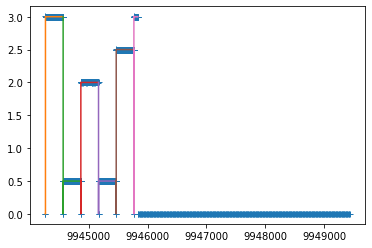

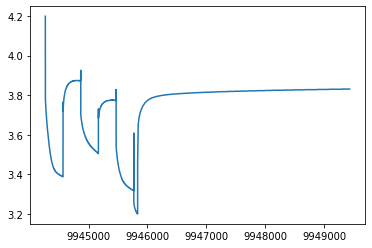

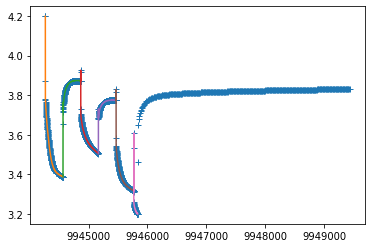

In [9]:
# mas graficos
idx = 600
plt.plot(t[idx], c[idx]), plt.show()
plt.plot(t[idx], c[idx], '+')

tiemposs = df.loc[(df['ciclo'] == idx), 'tiempo'].values
corrientos = df.loc[(df['ciclo'] == idx), 'corriente'].values

for i, tempp in enumerate(tiemposs):
    plt.plot(tempp, corrientos[i])#, plt.show()#, plt.show()
plt.show()

plt.plot(t[idx], v[idx]), plt.show()
plt.plot(t[idx], v[idx], '+')

tiemposs = df.loc[(df['ciclo'] == idx), 'tiempo'].values
voltajos = df.loc[(df['ciclo'] == idx), 'voltaje'].values

for i, tempp in enumerate(tiemposs):
    plt.plot(tempp, voltajos[i])#, plt.show()#, plt.show()
plt.show()


Análisis de histogramas, donde se pueden apreciar problemas con los datos. Pero son más gráficos solamente

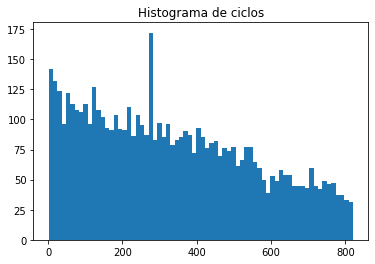

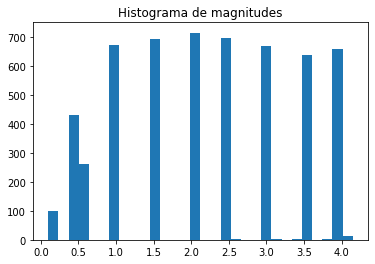

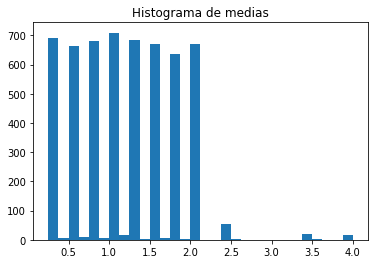

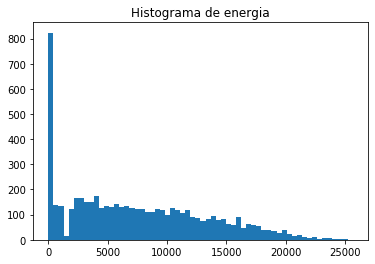

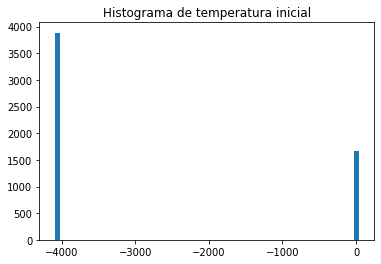

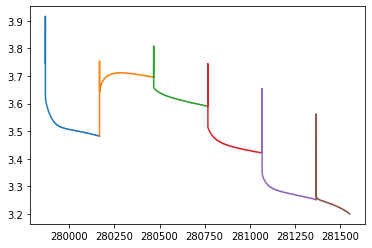

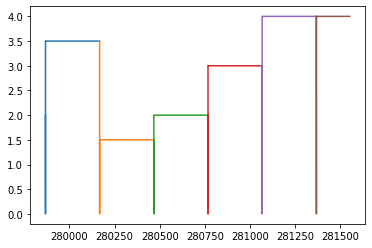

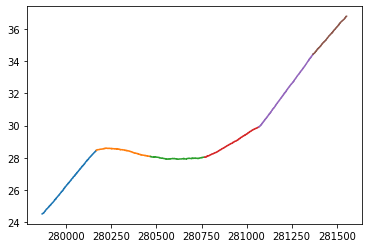

In [10]:
# analisis estadistico de los ciclos: ploteo de histogramas
plt.hist(df['ciclo'], bins=70), plt.title('Histograma de ciclos'), plt.show()
plt.hist(df['magnitud'], bins=30), plt.title('Histograma de magnitudes'), plt.show()
plt.hist(df['media'], bins=30), plt.title('Histograma de medias'), plt.show()
plt.hist(df['energia'], bins=60), plt.title('Histograma de energia'), plt.show()
# print(len(df))
# df_2['temp_ini'] = df['temp_ini'].drop(index=[df['temp_ini'] <= 0][0] * np.arange(0, len(df)))
# print(len(df_2))
plt.hist(df['temp_ini'], bins=60), plt.title('Histograma de temperatura inicial'), plt.show()

for i in range(3,9):
    plt.plot(df['tiempo'][i], df['voltaje'][i])
plt.show()

for i in range(3,9):
    plt.plot(df['tiempo'][i], df['corriente'][i])
plt.show()

for i in range(3,9):
    plt.plot(df['tiempo'][i], df['temperatura'][i])
plt.show()


## Features
A continuación, se definen los features a utilizar para encontrar tendencias entre los datos.

Primero, se quiere encontrar alguna relación con la componente resistiva de la respuesta dinámica, para ello se analiza la diferencia de voltaje entre los primeros instantes de tiempo. Hay que mejorar esto, ya que está medio hardcodeado, se debe analiza cuando la corriente no es nula

In [11]:
# definiendo features
def primera_derivada(arr_serie):
    aux = []
    for serie in arr_serie:
        serie = serie[2:]
        aux2 = list(serie[:-1] - serie[1:])
        if len(aux2) == 0: aux2 = [0]
        aux.append(aux2)
    return aux

#Delta tiempo
def deltaT(arr_serie, magnitud):
    aux = []
    for i in range(len(arr_serie)):
        if min(arr_serie[i])>0:
            delta = abs(arr_serie[i][-1]-arr_serie[i][0])/magnitud[i]
        else:
            delta = None
        aux.append(delta)   
    return aux

In [12]:
# obtener features

#RW3
df["F1"] = [np.mean(x[:1]) for x in primera_derivada(df["voltaje"])]
df["F2"] = [x for x in deltaT(df["temperatura"],df["magnitud"])]

#RW5
df_2["F1"] = [np.mean(x[:1]) for x in primera_derivada(df_2["voltaje"])]
df_2["F2"] = [x for x in deltaT(df_2["temperatura"],df_2["magnitud"])]



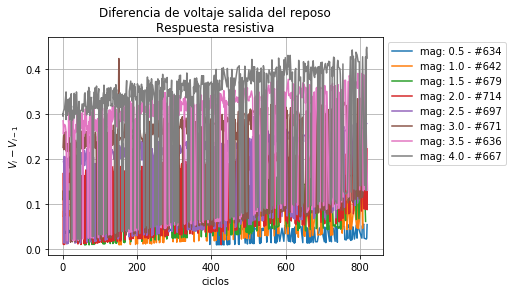

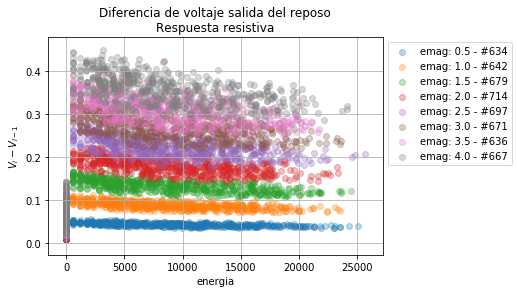

(<matplotlib.legend.Legend at 0x172f752ec18>, None, None)

In [13]:
WIN = 1
alpha = 0.3
df_aux = df[(df['magnitud'] >= 0.3) & (df['magnitud'] <= 0.7)]
df_aux = df_aux[df_aux['F1'] > 0.01]
df_aux['F1'] = df_aux['F1'].rolling(window=WIN).mean()
plt.plot(df_aux['ciclo'], df_aux['F1'], label='mag: 0.5 - #' + str(len(df_aux)))

df_aux = df[(df['magnitud'] >= 0.8) & (df['magnitud'] <= 1.2)]
df_aux = df_aux[df_aux['F1'] > 0.01]
df_aux['F1'] = df_aux['F1'].rolling(window=WIN).mean()
plt.plot(df_aux['ciclo'], df_aux['F1'], label='mag: 1.0 - #' + str(len(df_aux)))

df_aux = df[(df['magnitud'] >= 1.4) & (df['magnitud'] <= 1.6)]
df_aux = df_aux[df_aux['F1'] > 0.01]
df_aux['F1'] = df_aux['F1'].rolling(window=WIN).mean()
plt.plot(df_aux['ciclo'], df_aux['F1'], label='mag: 1.5 - #' + str(len(df_aux)))

df_aux = df[(df['magnitud'] >= 1.8) & (df['magnitud'] <= 2.2)]
df_aux = df_aux[df_aux['F1'] > 0.01]
df_aux['F1'] = df_aux['F1'].rolling(window=WIN).mean()
plt.plot(df_aux['ciclo'], df_aux['F1'], label='mag: 2.0 - #' + str(len(df_aux)))

df_aux = df[(df['magnitud'] >= 2.3) & (df['magnitud'] <= 2.7)]
df_aux = df_aux[df_aux['F1'] > 0.01]
df_aux['F1'] = df_aux['F1'].rolling(window=WIN).mean()
plt.plot(df_aux['ciclo'], df_aux['F1'], label='mag: 2.5 - #' + str(len(df_aux)))

df_aux = df[(df['magnitud'] >= 2.8) & (df['magnitud'] <= 3.2)]
df_aux = df_aux[df_aux['F1'] > 0.01]
df_aux['F1'] = df_aux['F1'].rolling(window=WIN).mean()
plt.plot(df_aux['ciclo'], df_aux['F1'], label='mag: 3.0 - #' + str(len(df_aux)))

df_aux = df[(df['magnitud'] >= 3.3) & (df['magnitud'] <= 3.7)]
df_aux = df_aux[df_aux['F1'] > 0.01]
df_aux['F1'] = df_aux['F1'].rolling(window=WIN).mean()
plt.plot(df_aux['ciclo'], df_aux['F1'], label='mag: 3.5 - #' + str(len(df_aux)))

df_aux = df[(df['magnitud'] >= 3.8) & (df['magnitud'] <= 4.2)]
df_aux = df_aux[df_aux['F1'] > 0.01]
df_aux['F1'] = df_aux['F1'].rolling(window=WIN).mean()
plt.plot(df_aux['ciclo'], df_aux['F1'], label='mag: 4.0 - #' + str(len(df_aux)))
plt.xlabel('ciclos')
plt.ylabel(r'$V_i - V_{i-1}$')
plt.title('Diferencia de voltaje salida del reposo\nRespuesta resistiva')
plt.legend(bbox_to_anchor=(1, 1)), plt.grid('on'), plt.show()

WIN = 1
alpha = 0.3
df_aux = df[(df['magnitud'] >= 0.3) & (df['magnitud'] <= 0.7)]
df_aux = df_aux[df_aux['F1'] > 0.01]
df_aux['F1'] = df_aux['F1'].rolling(window=WIN).mean()
plt.scatter(df_aux['energia'], df_aux['F1'], label='emag: 0.5 - #' + str(len(df_aux)), alpha=alpha)

df_aux = df[(df['magnitud'] >= 0.8) & (df['magnitud'] <= 1.2)]
df_aux = df_aux[df_aux['F1'] > 0.01]
df_aux['F1'] = df_aux['F1'].rolling(window=WIN).mean()
plt.scatter(df_aux['energia'], df_aux['F1'], label='emag: 1.0 - #' + str(len(df_aux)), alpha=alpha)

df_aux = df[(df['magnitud'] >= 1.4) & (df['magnitud'] <= 1.6)]
df_aux = df_aux[df_aux['F1'] > 0.01]
df_aux['F1'] = df_aux['F1'].rolling(window=WIN).mean()
plt.scatter(df_aux['energia'], df_aux['F1'], label='emag: 1.5 - #' + str(len(df_aux)), alpha=alpha)

df_aux = df[(df['magnitud'] >= 1.8) & (df['magnitud'] <= 2.2)]
df_aux = df_aux[df_aux['F1'] > 0.01]
df_aux['F1'] = df_aux['F1'].rolling(window=WIN).mean()
plt.scatter(df_aux['energia'], df_aux['F1'], label='emag: 2.0 - #' + str(len(df_aux)), alpha=alpha)

df_aux = df[(df['magnitud'] >= 2.3) & (df['magnitud'] <= 2.7)]
df_aux = df_aux[df_aux['F1'] > 0.01]
df_aux['F1'] = df_aux['F1'].rolling(window=WIN).mean()
plt.scatter(df_aux['energia'], df_aux['F1'], label='emag: 2.5 - #' + str(len(df_aux)), alpha=alpha)

df_aux = df[(df['magnitud'] >= 2.8) & (df['magnitud'] <= 3.2)]
df_aux = df_aux[df_aux['F1'] > 0.01]
df_aux['F1'] = df_aux['F1'].rolling(window=WIN).mean()
plt.scatter(df_aux['energia'], df_aux['F1'], label='emag: 3.0 - #' + str(len(df_aux)), alpha=alpha)

df_aux = df[(df['magnitud'] >= 3.3) & (df['magnitud'] <= 3.7)]
df_aux = df_aux[df_aux['F1'] > 0.01]
df_aux['F1'] = df_aux['F1'].rolling(window=WIN).mean()
plt.scatter(df_aux['energia'], df_aux['F1'], label='emag: 3.5 - #' + str(len(df_aux)), alpha=alpha)

df_aux = df[(df['magnitud'] >= 3.8) & (df['magnitud'] <= 4.2)]
df_aux = df_aux[df_aux['F1'] > 0.01]
df_aux['F1'] = df_aux['F1'].rolling(window=WIN).mean()
plt.scatter(df_aux['energia'], df_aux['F1'], label='emag: 4.0 - #' + str(len(df_aux)), alpha=alpha)
plt.xlabel('energia')
plt.ylabel(r'$V_i - V_{i-1}$')
plt.title('Diferencia de voltaje salida del reposo\nRespuesta resistiva')
plt.legend(bbox_to_anchor=(1, 1)), plt.grid('on'), plt.show()



Se puede ver en el gráfico anterior que hay una presencia importante de las respuestas a bajas energías, es decir, cuando ha entregado poca energía la batería. Eso se puede filtrar estableciendo un umbral inferior para la energía entregada (la etiqueta).

No handles with labels found to put in legend.


0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000


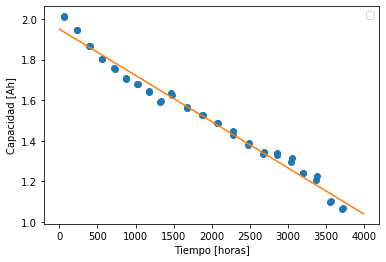

No handles with labels found to put in legend.


0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000


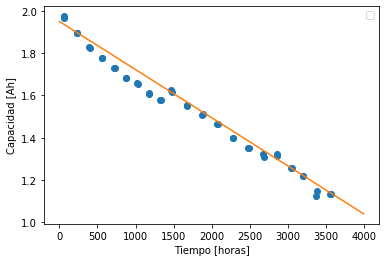

In [54]:
def plot_energia_magnitud(df, min,max, ei, ef, WIN, alpha):
    df_aux = df[(df['magnitud'] >= min) & (df['magnitud'] <= max)]
    df_aux = df_aux[(df['energia'] >= ei) & (df['energia'] <= ef)]
    df_aux = df_aux[df_aux['F1'] > 0.01]
    df_aux['F1'] = df_aux['F1'].rolling(window=WIN).mean()
    plt.plot(df_aux['ciclo'], df_aux['F1'],
             label='mag: ' + str((max+min)/2) + ' - #' + str(len(df_aux)) + ' i: ' + str(ei) + '-' + str(ef))
    
def plot_energia_magnitud_2(df, min,max, ei, ef, WIN, alpha,label_data):
    df_aux = df[(df['magnitud'] >= min) & (df['magnitud'] <= max)]
    df_aux = df_aux[(df['energia'] >= ei) & (df['energia'] <= ef)]
    df_aux = df_aux[df_aux['F1'] > 0.01]
    df_aux['F1'] = df_aux['F1'].rolling(window=WIN).mean()
    plt.plot(df_aux['ciclo'], df_aux['F1'],
             label='mag: ' + str((max+min)/2) + ' - #' + str(len(df_aux)) + ''+ 'data:' + label_data)
    
def plot_energia_magnitud_3(df, min,max, ei, ef, WIN, alpha,label_data,model):
    df_aux = df[(df['magnitud'] >= min) & (df['magnitud'] <= max)]
    df_aux = df_aux[(df['energia'] >= ei) & (df['energia'] <= ef)]
    df_aux = df_aux[df_aux['F1'] > 0.01]
    df_aux['F1'] = df_aux['F1'].rolling(window=WIN).mean()
    T_i = [x[0]/3600 for x in df_aux['tiempo']]
    SOH_pre = model.predict(np.reshape(T_i,(len(T_i),1)))
    plt.plot(SOH_pre, df_aux['F1'],
             label='mag: ' + str((max+min)/2) + ' - #' + str(len(df_aux)) + ''+ 'data:' + label_data)

from sklearn.linear_model import LinearRegression

#RW3
lista = [str('reference discharge')]
final = [str('rest post reference discharge')]
t_descarga, v_descarga, c_descarga, temp_descarga, T_descarga = carga_de_datos(documento, lista, final, nofinal=True)

# integrar la descarga
energia_entregada = []
T = []
for k in t_descarga.keys():
    energia_entregada.append(sum(c_descarga[k]) / 360)
    T.append(np.min(t_descarga[k]) / 3600)



model_1 = LinearRegression().fit(np.reshape(T,(44,1)), np.reshape(energia_entregada,(44,1)))
tt1 = np.arange(0,4000)
val1 = model_1.predict(np.reshape(tt1,(len(tt1),1)))
plt.plot(T,energia_entregada,'o',tt1,val1)
#plt.scatter(T, energia_entregada, label='descarga', facecolor='none', s=88, edgecolors='b', alpha=0.8)
plt.ylabel('Capacidad [Ah]')
plt.xlabel('Tiempo [horas]'),
plt.legend()
plt.show()

#RW5

lista_2 = [str('reference discharge')]
final_2 = [str('rest post reference discharge')]
t_descarga_2, v_descarga_2, c_descarga_2, temp_descarga_2, T_descarga_2 = carga_de_datos(documento_2, lista_2, final_2, nofinal=True)

# integrar la descarga
energia_entregada_2 = []
T_2 = []
for k in t_descarga_2.keys():
    energia_entregada_2.append(sum(c_descarga_2[k]) / 360)
    T_2.append(np.min(t_descarga[k]) / 3600)



model_2 = LinearRegression().fit(np.reshape(T,(44,1)), np.reshape(energia_entregada,(44,1)))
tt2 = np.arange(0,4000)
val2 = model_1.predict(np.reshape(tt2,(len(tt2),1)))
plt.plot(T_2,energia_entregada_2,'o',tt2,val2)
#plt.scatter(T, energia_entregada, label='descarga', facecolor='none', s=88, edgecolors='b', alpha=0.8)
plt.ylabel('Capacidad [Ah]')
plt.xlabel('Tiempo [horas]'),
plt.legend()
plt.show()

C:\Users\cbaez\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


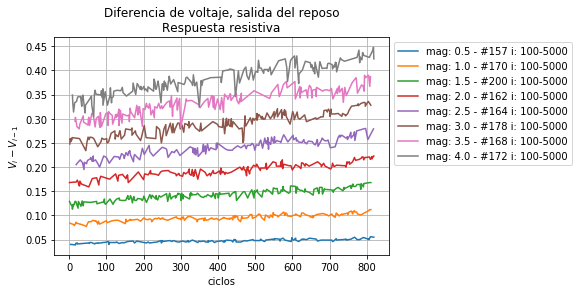

(<matplotlib.legend.Legend at 0x1728a858b38>, None, None)

In [55]:

WIN = 1
plot_energia_magnitud(df, 0.3,0.7, 100, 5000, WIN, alpha)
# plot_energia_magnitud(df, 0.5, 10000, 15000, WIN, alpha)
# plot_energia_magnitud(df, 0.5, 15000, 20000, WIN, alpha)
# plot_energia_magnitud(df, 0.5, 20000, 25000, WIN, alpha)
# plt.legend(bbox_to_anchor=(1, 1)), plt.grid('on'), plt.show()

plot_energia_magnitud(df, 0.8,1.2, 100, 5000, WIN, alpha)
# plot_energia_magnitud(df, 1.0, 10000, 15000, WIN, alpha)
# plot_energia_magnitud(df, 1.0, 15000, 20000, WIN, alpha)
# plot_energia_magnitud(df, 1.0, 20000, 25000, WIN, alpha)
# plt.legend(bbox_to_anchor=(1, 1)), plt.grid('on'), plt.show()

plot_energia_magnitud(df, 1.3,1.7, 100, 5000, WIN, alpha)
# plot_energia_magnitud(df, 1.5, 10000, 15000, WIN, alpha)
# plot_energia_magnitud(df, 1.5, 15000, 20000, WIN, alpha)
# plot_energia_magnitud(df, 1.5, 20000, 25000, WIN, alpha)
# plt.legend(bbox_to_anchor=(1, 1)), plt.grid('on'), plt.show()

plot_energia_magnitud(df, 1.8,2.2, 100, 5000, WIN, alpha)
# plot_energia_magnitud(df, 2.0, 10000, 15000, WIN, alpha)
# plot_energia_magnitud(df, 2.0, 15000, 20000, WIN, alpha)
# plot_energia_magnitud(df, 2.0, 20000, 25000, WIN, alpha)
# plt.legend(bbox_to_anchor=(1, 1)), plt.grid('on'), plt.show()

plot_energia_magnitud(df, 2.3,2.7, 100, 5000, WIN, alpha)
# plot_energia_magnitud(df, 2.5, 10000, 15000, WIN, alpha)
# plot_energia_magnitud(df, 2.5, 15000, 20000, WIN, alpha)
# plot_energia_magnitud(df, 2.5, 20000, 25000, WIN, alpha)
# plt.legend(bbox_to_anchor=(1, 1)), plt.grid('on'), plt.show()

plot_energia_magnitud(df, 2.8,3.2, 100, 5000, WIN, alpha)
# plot_energia_magnitud(df, 3.0, 10000, 15000, WIN, alpha)
# plot_energia_magnitud(df, 3.0, 15000, 20000, WIN, alpha)
# plot_energia_magnitud(df, 3.0, 20000, 25000, WIN, alpha)
# plt.legend(bbox_to_anchor=(1, 1)), plt.grid('on'), plt.show()

plot_energia_magnitud(df, 3.3,3.7, 100, 5000, WIN, alpha)
# plot_energia_magnitud(df, 3.5, 10000, 15000, WIN, alpha)
# plot_energia_magnitud(df, 3.5, 15000, 20000, WIN, alpha)
# plot_energia_magnitud(df, 3.5, 20000, 25000, WIN, alpha)
# plt.legend(bbox_to_anchor=(1, 1)), plt.grid('on'), plt.show()

plot_energia_magnitud(df, 3.8,4.2, 100, 5000, WIN, alpha)
# plot_energia_magnitud(df, 4.0, 10000, 15000, WIN, alpha)
# plot_energia_magnitud(df, 4.0, 15000, 20000, WIN, alpha)
# plot_energia_magnitud(df, 4.0, 20000, 25000, WIN, alpha)
plt.title('Diferencia de voltaje, salida del reposo\nRespuesta resistiva')
plt.xlabel('ciclos')
plt.ylabel(r'$V_i - V_{i-1}$')
plt.legend(bbox_to_anchor=(1, 1)), plt.grid('on'), plt.show()


C:\Users\cbaez\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


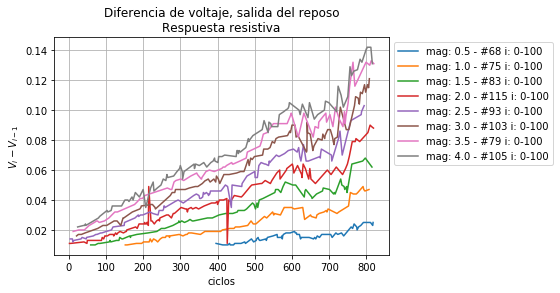

(<matplotlib.legend.Legend at 0x1728bd07128>, None, None)

In [56]:
WIN = 1
alpha = 0.3
plot_energia_magnitud(df, 0.3,0.7,0, 100, WIN, alpha)
# plot_energia_magnitud(df, 0.5, 10000, 15000, WIN, alpha)
# plot_energia_magnitud(df, 0.5, 15000, 20000, WIN, alpha)
# plot_energia_magnitud(df, 0.5, 20000, 25000, WIN, alpha)
# plt.legend(bbox_to_anchor=(1, 1)), plt.grid('on'), plt.show()

plot_energia_magnitud(df, 0.8,1.2, 0, 100, WIN, alpha)
# plot_energia_magnitud(df, 1.0, 10000, 15000, WIN, alpha)
# plot_energia_magnitud(df, 1.0, 15000, 20000, WIN, alpha)
# plot_energia_magnitud(df, 1.0, 20000, 25000, WIN, alpha)
# plt.legend(bbox_to_anchor=(1, 1)), plt.grid('on'), plt.show()

plot_energia_magnitud(df, 1.3,1.7, 0, 100, WIN, alpha)
# plot_energia_magnitud(df, 1.5, 10000, 15000, WIN, alpha)
# plot_energia_magnitud(df, 1.5, 15000, 20000, WIN, alpha)
# plot_energia_magnitud(df, 1.5, 20000, 25000, WIN, alpha)
# plt.legend(bbox_to_anchor=(1, 1)), plt.grid('on'), plt.show()

plot_energia_magnitud(df, 1.8,2.2, 0, 100, WIN, alpha)
# plot_energia_magnitud(df, 2.0, 10000, 15000, WIN, alpha)
# plot_energia_magnitud(df, 2.0, 15000, 20000, WIN, alpha)
# plot_energia_magnitud(df, 2.0, 20000, 25000, WIN, alpha)
# plt.legend(bbox_to_anchor=(1, 1)), plt.grid('on'), plt.show()

plot_energia_magnitud(df, 2.3,2.7, 0, 100, WIN, alpha)
# plot_energia_magnitud(df, 2.5, 10000, 15000, WIN, alpha)
# plot_energia_magnitud(df, 2.5, 15000, 20000, WIN, alpha)
# plot_energia_magnitud(df, 2.5, 20000, 25000, WIN, alpha)
# plt.legend(bbox_to_anchor=(1, 1)), plt.grid('on'), plt.show()

plot_energia_magnitud(df, 2.8,3.2, 0, 100, WIN, alpha)
# plot_energia_magnitud(df, 3.0, 10000, 15000, WIN, alpha)
# plot_energia_magnitud(df, 3.0, 15000, 20000, WIN, alpha)
# plot_energia_magnitud(df, 3.0, 20000, 25000, WIN, alpha)
# plt.legend(bbox_to_anchor=(1, 1)), plt.grid('on'), plt.show()

plot_energia_magnitud(df, 3.3,3.7, 0, 100, WIN, alpha)
# plot_energia_magnitud(df, 3.5, 10000, 15000, WIN, alpha)
# plot_energia_magnitud(df, 3.5, 15000, 20000, WIN, alpha)
# plot_energia_magnitud(df, 3.5, 20000, 25000, WIN, alpha)
# plt.legend(bbox_to_anchor=(1, 1)), plt.grid('on'), plt.show()


plot_energia_magnitud(df, 3.8,4.2, 0, 100, WIN, alpha)
# plot_energia_magnitud(df, 4.0, 10000, 15000, WIN, alpha)
# plot_energia_magnitud(df, 4.0, 15000, 20000, WIN, alpha)
# plot_energia_magnitud(df, 4.0, 20000, 25000, WIN, alpha)
plt.title('Diferencia de voltaje, salida del reposo\nRespuesta resistiva')
plt.xlabel('ciclos')
plt.ylabel(r'$V_i - V_{i-1}$')
plt.legend(bbox_to_anchor=(1, 1)), plt.grid('on'), plt.show()


C:\Users\cbaez\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\cbaez\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\cbaez\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\cbaez\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\cbaez\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\cbaez\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\cbaez\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Boolean Series key will be reindexed to match Da

(<matplotlib.legend.Legend at 0x172881c52b0>, None)

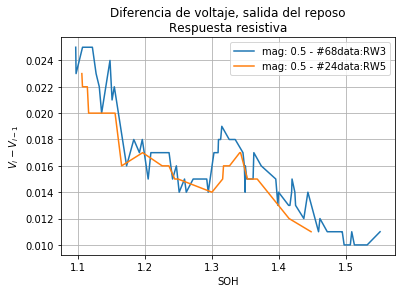

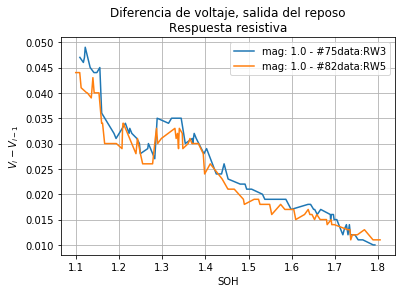

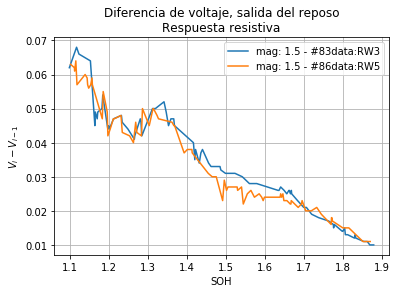

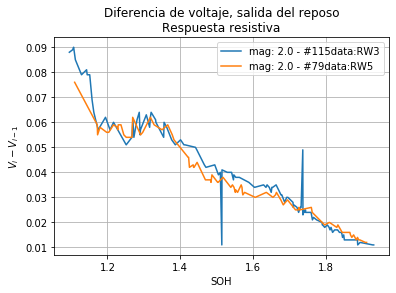

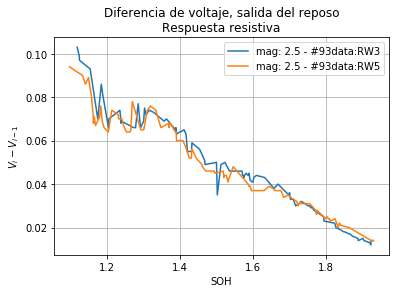

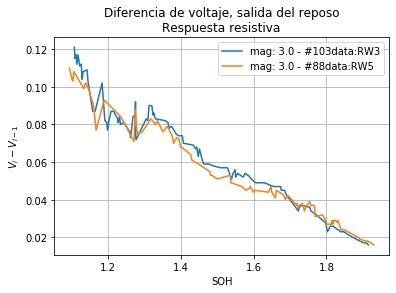

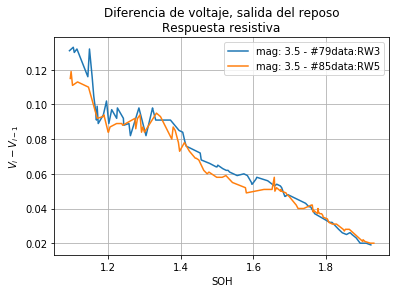

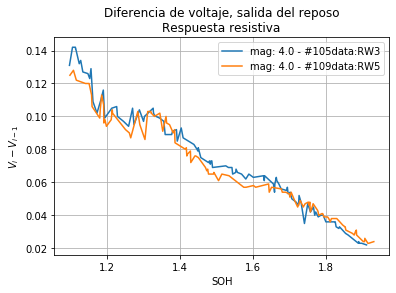

In [57]:
WIN = 1
alpha = 0.3
plt.figure()
plot_energia_magnitud_3(df, 0.3,0.7,0, 100, WIN, alpha , 'RW3',model_1)
plot_energia_magnitud_3(df_2, 0.3,0.7,0, 100, WIN, alpha, 'RW5',model_2)

plt.title('Diferencia de voltaje, salida del reposo\nRespuesta resistiva')
plt.xlabel('SOH')
plt.ylabel(r'$V_i - V_{i-1}$')
plt.legend(bbox_to_anchor=(1, 1)), plt.grid('on')

plt.figure()
plot_energia_magnitud_3(df, 0.8,1.2,0, 100, WIN, alpha, 'RW3',model_1)
plot_energia_magnitud_3(df_2, 0.8,1.2,0, 100, WIN, alpha, 'RW5',model_2)

plt.title('Diferencia de voltaje, salida del reposo\nRespuesta resistiva')
plt.xlabel('SOH')
plt.ylabel(r'$V_i - V_{i-1}$')
plt.legend(bbox_to_anchor=(1, 1)), plt.grid('on')

plt.figure()
plot_energia_magnitud_3(df, 1.3,1.7,0, 100, WIN, alpha, 'RW3',model_1)
plot_energia_magnitud_3(df_2, 1.3,1.7,0, 100, WIN, alpha, 'RW5',model_2)

plt.title('Diferencia de voltaje, salida del reposo\nRespuesta resistiva')
plt.xlabel('SOH')
plt.ylabel(r'$V_i - V_{i-1}$')
plt.legend(bbox_to_anchor=(1, 1)), plt.grid('on')

plt.figure()
plot_energia_magnitud_3(df, 1.8,2.2,0, 100, WIN, alpha, 'RW3',model_1)
plot_energia_magnitud_3(df_2, 1.8,2.2,0, 100, WIN, alpha, 'RW5',model_2)

plt.title('Diferencia de voltaje, salida del reposo\nRespuesta resistiva')
plt.xlabel('SOH')
plt.ylabel(r'$V_i - V_{i-1}$')
plt.legend(bbox_to_anchor=(1, 1)), plt.grid('on')

plt.figure()
plot_energia_magnitud_3(df, 2.3,2.7,0, 100, WIN, alpha, 'RW3',model_1)
plot_energia_magnitud_3(df_2, 2.3,2.7,0, 100, WIN, alpha, 'RW5',model_2)

plt.title('Diferencia de voltaje, salida del reposo\nRespuesta resistiva')
plt.xlabel('SOH')
plt.ylabel(r'$V_i - V_{i-1}$')
plt.legend(bbox_to_anchor=(1, 1)), plt.grid('on')

plt.figure()
plot_energia_magnitud_3(df, 2.8,3.2,0, 100, WIN, alpha, 'RW3',model_1)
plot_energia_magnitud_3(df_2, 2.8,3.2,0, 100, WIN, alpha, 'RW5',model_2)

plt.title('Diferencia de voltaje, salida del reposo\nRespuesta resistiva')
plt.xlabel('SOH')
plt.ylabel(r'$V_i - V_{i-1}$')
plt.legend(bbox_to_anchor=(1, 1)), plt.grid('on')

plt.figure()
plot_energia_magnitud_3(df, 3.3,3.7,0, 100, WIN, alpha, 'RW3',model_1)
plot_energia_magnitud_3(df_2, 3.3,3.7,0, 100, WIN, alpha, 'RW5',model_2)

plt.title('Diferencia de voltaje, salida del reposo\nRespuesta resistiva')
plt.xlabel('SOH')
plt.ylabel(r'$V_i - V_{i-1}$')
plt.legend(bbox_to_anchor=(1, 1)), plt.grid('on')

plt.figure()
plot_energia_magnitud_3(df, 3.8,4.2,0, 100, WIN, alpha, 'RW3',model_1)
plot_energia_magnitud_3(df_2, 3.8,4.2,0, 100, WIN, alpha, 'RW5',model_2)

plt.title('Diferencia de voltaje, salida del reposo\nRespuesta resistiva')
plt.xlabel('SOH')
plt.ylabel(r'$V_i - V_{i-1}$')
plt.legend(bbox_to_anchor=(1, 1)), plt.grid('on')

In [ ]:
# comportamiento de potencia instantanea entregada
def potencia_instantanea_salto(arr_voltaje, arr_corriente, limite=10):
    aux = np.zeros(len(arr_voltaje))
    for i, serie in enumerate(arr_corriente):
        serie = serie[1:]
        contador = 0
        for j, c in enumerate(serie):
            if c != 0 and aux[i] == 0:
                aux[i] = c * arr_voltaje[i][j]
                contador = 1
            elif c != 0 and contador < limite:
                aux[i] += c * arr_voltaje[i][j]
                contador += 1
            elif contador == limite: break
            
    return aux

In [ ]:
df['F1'] = potencia_instantanea_salto(df['voltaje'], df['corriente'], limite=1)
df

In [ ]:
WIN = 1
df_aux = df[(df['magnitud'] >= 0.3) & (df['magnitud'] <= 0.7)]
df_aux = df_aux[df_aux['F1'] > 0.01]
df_aux['F1'] = df_aux['F1'].rolling(window=WIN).mean()
plt.plot(df_aux['ciclo'], df_aux['F1'], label='mag: 0.5 - #' + str(len(df_aux)))

df_aux = df[(df['magnitud'] >= 0.8) & (df['magnitud'] <= 1.2)]
df_aux = df_aux[df_aux['F1'] > 0.01]
df_aux['F1'] = df_aux['F1'].rolling(window=WIN).mean()
plt.plot(df_aux['ciclo'], df_aux['F1'], label='mag: 1.0 - #' + str(len(df_aux)))

df_aux = df[(df['magnitud'] >= 1.4) & (df['magnitud'] <= 1.6)]
df_aux = df_aux[df_aux['F1'] > 0.01]
df_aux['F1'] = df_aux['F1'].rolling(window=WIN).mean()
plt.plot(df_aux['ciclo'], df_aux['F1'], label='mag: 1.5 - #' + str(len(df_aux)))

df_aux = df[(df['magnitud'] >= 1.8) & (df['magnitud'] <= 2.2)]
df_aux = df_aux[df_aux['F1'] > 0.01]
df_aux['F1'] = df_aux['F1'].rolling(window=WIN).mean()
plt.plot(df_aux['ciclo'], df_aux['F1'], label='mag: 2.0 - #' + str(len(df_aux)))

df_aux = df[(df['magnitud'] >= 2.3) & (df['magnitud'] <= 2.7)]
df_aux = df_aux[df_aux['F1'] > 0.01]
df_aux['F1'] = df_aux['F1'].rolling(window=WIN).mean()
plt.plot(df_aux['ciclo'], df_aux['F1'], label='mag: 2.5 - #' + str(len(df_aux)))

df_aux = df[(df['magnitud'] >= 2.8) & (df['magnitud'] <= 3.2)]
df_aux = df_aux[df_aux['F1'] > 0.01]
df_aux['F1'] = df_aux['F1'].rolling(window=WIN).mean()
plt.plot(df_aux['ciclo'], df_aux['F1'], label='mag: 3.0 - #' + str(len(df_aux)))

# df_aux = df[(df['magnitud'] >= 3.3) & (df['magnitud'] <= 3.7)]
# df_aux = df_aux[df_aux['F1'] > 0.01]
# df_aux['F1'] = df_aux['F1'].rolling(window=WIN).mean()
# plt.plot(df_aux['ciclo'], df_aux['F1'], label='mag: 3.5 - #' + str(len(df_aux)))

# df_aux = df[(df['magnitud'] >= 3.8) & (df['magnitud'] <= 4.2)]
# df_aux = df_aux[df_aux['F1'] > 0.01]
# df_aux['F1'] = df_aux['F1'].rolling(window=WIN).mean()
# plt.plot(df_aux['ciclo'], df_aux['F1'], label='mag: 4.0 - #' + str(len(df_aux)))
plt.xlabel('ciclos')
plt.ylabel(r'$\min_i \ V_i \times I_i \ \ne \ 0$')
plt.title('Potencia entregada al instante despues del salto')
plt.legend(bbox_to_anchor=(1, 1)), plt.grid('on'), plt.show()

WIN = 1
alpha = 0.3
df_aux = df[(df['magnitud'] >= 0.3) & (df['magnitud'] <= 0.7)]
df_aux = df_aux[df_aux['F1'] > 0.01]
df_aux['F1'] = df_aux['F1'].rolling(window=WIN).mean()
plt.scatter(df_aux['energia'], df_aux['F1'], label='emag: 0.5 - #' + str(len(df_aux)), alpha=alpha)

df_aux = df[(df['magnitud'] >= 0.8) & (df['magnitud'] <= 1.2)]
df_aux = df_aux[df_aux['F1'] > 0.01]
df_aux['F1'] = df_aux['F1'].rolling(window=WIN).mean()
plt.scatter(df_aux['energia'], df_aux['F1'], label='emag: 1.0 - #' + str(len(df_aux)), alpha=alpha)

df_aux = df[(df['magnitud'] >= 1.4) & (df['magnitud'] <= 1.6)]
df_aux = df_aux[df_aux['F1'] > 0.01]
df_aux['F1'] = df_aux['F1'].rolling(window=WIN).mean()
plt.scatter(df_aux['energia'], df_aux['F1'], label='emag: 1.5 - #' + str(len(df_aux)), alpha=alpha)

df_aux = df[(df['magnitud'] >= 1.8) & (df['magnitud'] <= 2.2)]
df_aux = df_aux[df_aux['F1'] > 0.01]
df_aux['F1'] = df_aux['F1'].rolling(window=WIN).mean()
plt.scatter(df_aux['energia'], df_aux['F1'], label='emag: 2.0 - #' + str(len(df_aux)), alpha=alpha)

df_aux = df[(df['magnitud'] >= 2.3) & (df['magnitud'] <= 2.7)]
df_aux = df_aux[df_aux['F1'] > 0.01]
df_aux['F1'] = df_aux['F1'].rolling(window=WIN).mean()
plt.scatter(df_aux['energia'], df_aux['F1'], label='emag: 2.5 - #' + str(len(df_aux)), alpha=alpha)

df_aux = df[(df['magnitud'] >= 2.8) & (df['magnitud'] <= 3.2)]
df_aux = df_aux[df_aux['F1'] > 0.01]
df_aux['F1'] = df_aux['F1'].rolling(window=WIN).mean()
plt.scatter(df_aux['energia'], df_aux['F1'], label='emag: 3.0 - #' + str(len(df_aux)), alpha=alpha)

# df_aux = df[(df['magnitud'] >= 3.3) & (df['magnitud'] <= 3.7)]
# df_aux = df_aux[df_aux['F1'] > 0.01]
# df_aux['F1'] = df_aux['F1'].rolling(window=WIN).mean()
# plt.scatter(df_aux['energia'], df_aux['F1'], label='emag: 3.5 - #' + str(len(df_aux)), alpha=alpha)

# df_aux = df[(df['magnitud'] >= 3.8) & (df['magnitud'] <= 4.2)]
# df_aux = df_aux[df_aux['F1'] > 0.01]
# df_aux['F1'] = df_aux['F1'].rolling(window=WIN).mean()
# plt.scatter(df_aux['energia'], df_aux['F1'], label='emag: 4.0 - #' + str(len(df_aux)), alpha=alpha)
plt.xlabel('energia')
plt.ylabel(r'$\min_i \ V_i \times I_i \ \ne \ 0$')
plt.title('Potencia entregada al instante despues del salto')
plt.legend(bbox_to_anchor=(1, 1)), plt.grid('on'), plt.show()



In [ ]:
WIN = 5
plot_energia_magnitud(df, 0.5, 100, 5000, WIN, alpha)
# plot_energia_magnitud(df, 0.5, 10000, 15000, WIN, alpha)
# plot_energia_magnitud(df, 0.5, 15000, 20000, WIN, alpha)
# plot_energia_magnitud(df, 0.5, 20000, 25000, WIN, alpha)
# plt.legend(bbox_to_anchor=(1, 1)), plt.grid('on'), plt.show()

plot_energia_magnitud(df, 1.0, 100, 5000, WIN, alpha)
# plot_energia_magnitud(df, 1.0, 10000, 15000, WIN, alpha)
# plot_energia_magnitud(df, 1.0, 15000, 20000, WIN, alpha)
# plot_energia_magnitud(df, 1.0, 20000, 25000, WIN, alpha)
# plt.legend(bbox_to_anchor=(1, 1)), plt.grid('on'), plt.show()

plot_energia_magnitud(df, 1.5, 100, 5000, WIN, alpha)
# plot_energia_magnitud(df, 1.5, 10000, 15000, WIN, alpha)
# plot_energia_magnitud(df, 1.5, 15000, 20000, WIN, alpha)
# plot_energia_magnitud(df, 1.5, 20000, 25000, WIN, alpha)
# plt.legend(bbox_to_anchor=(1, 1)), plt.grid('on'), plt.show()

plot_energia_magnitud(df, 2.0, 100, 5000, WIN, alpha)
# plot_energia_magnitud(df, 2.0, 10000, 15000, WIN, alpha)
# plot_energia_magnitud(df, 2.0, 15000, 20000, WIN, alpha)
# plot_energia_magnitud(df, 2.0, 20000, 25000, WIN, alpha)
# plt.legend(bbox_to_anchor=(1, 1)), plt.grid('on'), plt.show()

plot_energia_magnitud(df, 2.5, 100, 5000, WIN, alpha)
# plot_energia_magnitud(df, 2.5, 10000, 15000, WIN, alpha)
# plot_energia_magnitud(df, 2.5, 15000, 20000, WIN, alpha)
# plot_energia_magnitud(df, 2.5, 20000, 25000, WIN, alpha)
# plt.legend(bbox_to_anchor=(1, 1)), plt.grid('on'), plt.show()

plot_energia_magnitud(df, 3.0, 100, 5000, WIN, alpha)
# plot_energia_magnitud(df, 3.0, 10000, 15000, WIN, alpha)
# plot_energia_magnitud(df, 3.0, 15000, 20000, WIN, alpha)
# plot_energia_magnitud(df, 3.0, 20000, 25000, WIN, alpha)
# plt.legend(bbox_to_anchor=(1, 1)), plt.grid('on'), plt.show()

plot_energia_magnitud(df, 3.5, 100, 5000, WIN, alpha)
# plot_energia_magnitud(df, 3.5, 10000, 15000, WIN, alpha)
# plot_energia_magnitud(df, 3.5, 15000, 20000, WIN, alpha)
# plot_energia_magnitud(df, 3.5, 20000, 25000, WIN, alpha)
# plt.legend(bbox_to_anchor=(1, 1)), plt.grid('on'), plt.show()

plot_energia_magnitud(df, 4.0, 100, 5000, WIN, alpha)
# plot_energia_magnitud(df, 4.0, 10000, 15000, WIN, alpha)
# plot_energia_magnitud(df, 4.0, 15000, 20000, WIN, alpha)
# plot_energia_magnitud(df, 4.0, 20000, 25000, WIN, alpha)
plt.ylabel(r'$\min_i \ V_i \times I_i \ \ne \ 0$')
plt.title('Potencia entregada al instante despues del salto')
plt.xlabel('ciclos')
plt.legend(bbox_to_anchor=(1, 1)), plt.grid('on'), plt.show()


In [ ]:
def tiempo_a_inflexion(arr_voltaje):
    """
    funcion que entrega el tiempo necesario a la inflexion
    """
    
    
    
    return

Trabajo próximo:
- guardar curvas hasta el salto anterior (instante antes de 0)
- guardar voltaje anterior como etiqueta
- guardar temperatura inicial como etiqueta
- Para feature de degradación usar delta T del salto completo (inicio - fin)
- Ver fenomenolgía del circuito RC, ajustar función de transferencia de modelo RC
    - para encontrar la constante de proporcionalidad, tomar curvas de voltaje 'estables' donde $V_{i+1} - V_{i} < \epsilon$
    - Encontrar constante de tiempo entre esas curvas

# Grafico de curva de salud

In [ ]:
# lista = [str('reference charge')]
# final = [str('rest post reference charge')]
# t_carga, v_carga, c_carga, temp_carga, T_carga = carga_de_datos(documento, lista, final, nofinal=True)

lista = [str('reference discharge')]
final = [str('rest post reference discharge')]
t_descarga, v_descarga, c_descarga, temp_descarga, T_descarga = carga_de_datos(documento, lista, final, nofinal=True)


In [ ]:
# integrar la descarga
energia_entregada = []
T = []
for k in t_descarga.keys():
    energia_entregada.append(sum(c_descarga[k]) / 360)
    T.append(np.min(t_descarga[k]) / 3600)
plt.scatter(T, energia_entregada, label='descarga', facecolor='none', s=88, edgecolors='b', alpha=0.8)
plt.ylabel('Capacidad [Ah]')
plt.xlabel('Tiempo [horas]')
plt.legend()

# plt.title('Capacidad de energía entregada por batería'), plt.show()

# # integrar la carga
# energia_entregada = []
# T = []
# for k in t_carga.keys():
#     energia_entregada.append(sum(c_carga[k]) / 360)
#     T.append(np.mean(t_carga[k]) / 3600)
# # plt.scatter(T, np.abs(energia_entregada), label='carga', s=38, edgecolors='b', alpha=0.4)
# plt.ylabel('Capacidad [Ah]')
# plt.xlabel('Tiempo [horas]')
# plt.legend()
# plt.title('Capacidad de energía'), plt.show()


[ciclo, potencia, media y magnitud del salto] como identidad de un salto, a partir de ello obtener una respuesta dinamica con features